In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


Reading the data

In [3]:
%time df = pd.read_csv('/Users/mahaksharma/Downloads/globalterrorismdb_0617dist.csv', low_memory=False,encoding='Latin-1')

CPU times: user 5 s, sys: 716 ms, total: 5.71 s
Wall time: 6.09 s


In [4]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
df.shape

(170350, 135)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Columns: 135 entries, eventid to related
dtypes: float64(53), int64(24), object(58)
memory usage: 175.5+ MB


Checking Null values

In [7]:
check_nulls = df.isnull().sum().sort_values(ascending=False)
check_nulls.head()

gsubname3           170337
weapsubtype4_txt    170279
weapsubtype4        170279
weaptype4           170276
weaptype4_txt       170276
dtype: int64

In [8]:
row_count = df.shape[0]
check_nulls_percentage = 100 * check_nulls / row_count
check_nulls_percentage.head()

gsubname3           99.992369
weapsubtype4_txt    99.958321
weapsubtype4        99.958321
weaptype4           99.956560
weaptype4_txt       99.956560
dtype: float64

In [9]:
bins = (-1, 0, 25, 50, 75, 100)
labels = ['0 %','1-25 %','25-50 %','50-75 %','75-100 %']

check_nulls_percentage_grouped = pd.cut(check_nulls_percentage, bins, labels=labels)
check_nulls_percentage_grouped.head()

gsubname3           75-100 %
weapsubtype4_txt    75-100 %
weapsubtype4        75-100 %
weaptype4           75-100 %
weaptype4_txt       75-100 %
dtype: category
Categories (5, object): [0 % < 1-25 % < 25-50 % < 50-75 % < 75-100 %]

In [10]:
check_nulls_percentage_grouped_counts = check_nulls_percentage_grouped.value_counts()
check_nulls_percentage_grouped_counts.sort_index()

0 %         31
1-25 %      17
25-50 %     10
50-75 %      7
75-100 %    70
dtype: int64

Text(0,0.5,'Number of Columns')

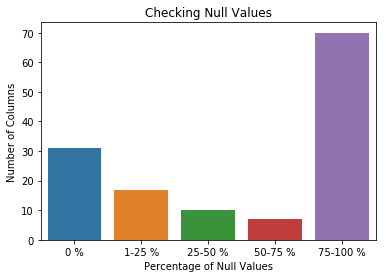

In [11]:
sns.barplot(check_nulls_percentage_grouped_counts.index, check_nulls_percentage_grouped_counts.values)
plt.title('Checking Null Values')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Number of Columns')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Columns: 135 entries, eventid to related
dtypes: float64(53), int64(24), object(58)
memory usage: 175.5+ MB


In [13]:
cols_float = df.select_dtypes(include=['float64']).columns
cols_float

Index(['latitude', 'longitude', 'specificity', 'alternative', 'attacktype2',
       'attacktype3', 'targsubtype1', 'natlty1', 'targtype2', 'targsubtype2',
       'natlty2', 'targtype3', 'targsubtype3', 'natlty3', 'guncertain1',
       'guncertain2', 'guncertain3', 'nperps', 'nperpcap', 'claimed',
       'claimmode', 'claim2', 'claimmode2', 'claim3', 'claimmode3',
       'compclaim', 'weapsubtype1', 'weaptype2', 'weapsubtype2', 'weaptype3',
       'weapsubtype3', 'weaptype4', 'weapsubtype4', 'nkill', 'nkillus',
       'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'propextent', 'propvalue',
       'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'ransom',
       'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus',
       'hostkidoutcome', 'nreleased'],
      dtype='object')

In [14]:
df[cols_float].head(3)

,latitude,longitude,specificity,alternative,attacktype2,attacktype3,targsubtype1,natlty1,targtype2,targsubtype2,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased
0,18.456792,-69.951164,1.0,NaN,NaN,NaN,68.0,58.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,19.432608,-99.133207,1.0,NaN,NaN,NaN,45.0,21.0,NaN,NaN,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,NaN
2,15.478598,120.599741,4.0,NaN,NaN,NaN,54.0,217.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
cols_int = df.select_dtypes(include=['int64']).columns
cols_int

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'region',
       'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple',
       'success', 'suicide', 'attacktype1', 'targtype1', 'individual',
       'weaptype1', 'property', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

In [16]:
df[cols_int].head(3)

,eventid,iyear,imonth,iday,extended,country,region,vicinity,crit1,crit2,...,suicide,attacktype1,targtype1,individual,weaptype1,property,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,2,0,1,1,...,0,1,14,0,13,0,0,0,0,0
1,197000000002,1970,0,0,0,130,1,0,1,1,...,0,6,7,0,13,0,0,1,1,1
2,197001000001,1970,1,0,0,160,5,0,1,1,...,0,1,10,0,13,0,-9,-9,1,1


In [17]:
cols_object = df.select_dtypes(include=['object']).columns
cols_object

Index(['approxdate', 'resolution', 'country_txt', 'region_txt', 'provstate',
       'city', 'location', 'summary', 'alternative_txt', 'attacktype1_txt',
       'attacktype2_txt', 'attacktype3_txt', 'targtype1_txt',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1_txt', 'targtype2_txt',
       'targsubtype2_txt', 'corp2', 'target2', 'natlty2_txt', 'targtype3_txt',
       'targsubtype3_txt', 'corp3', 'target3', 'natlty3_txt', 'gname',
       'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive',
       'claimmode_txt', 'claimmode2_txt', 'claimmode3_txt', 'weaptype1_txt',
       'weapsubtype1_txt', 'weaptype2_txt', 'weapsubtype2_txt',
       'weaptype3_txt', 'weapsubtype3_txt', 'weaptype4_txt',
       'weapsubtype4_txt', 'weapdetail', 'propextent_txt', 'propcomment',
       'divert', 'kidhijcountry', 'ransomnote', 'hostkidoutcome_txt',
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'related'],
      dtype='object')

In [18]:
df[cols_object].head(3)

,approxdate,resolution,country_txt,region_txt,provstate,city,location,summary,alternative_txt,attacktype1_txt,...,divert,kidhijcountry,ransomnote,hostkidoutcome_txt,addnotes,scite1,scite2,scite3,dbsource,related
0,NaN,NaN,Dominican Republic,Central America & Caribbean,NaN,Santo Domingo,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
1,NaN,NaN,Mexico,North America,NaN,Mexico city,NaN,NaN,NaN,Hostage Taking (Kidnapping),...,NaN,Mexico,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN
2,NaN,NaN,Philippines,Southeast Asia,Tarlac,Unknown,NaN,NaN,NaN,Assassination,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN


Groups known and unknown

In [19]:
df.gname.isnull().sum()

0

In [20]:
grp_counts = df.gname.value_counts()
grp_counts.head(10)

Unknown                                             78306
Taliban                                              6575
Shining Path (SL)                                    4551
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Al-Shabaab                                           2683
Irish Republican Army (IRA)                          2669
Revolutionary Armed Forces of Colombia (FARC)        2481
New People's Army (NPA)                              2414
Kurdistan Workers' Party (PKK)                       2152
Name: gname, dtype: int64

In [21]:
grp_counts_known = grp_counts.loc[grp_counts.index != 'Unknown'].sum()
grp_counts_known

92044

In [22]:
grp_counts_unknown = grp_counts[0]
grp_counts_unknown

78306

Text(0,0.5,'Percentage of Attacks')

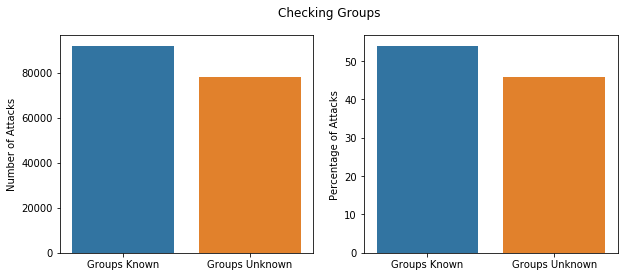

In [23]:
fig, (a0, a1) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Checking Groups')

sns.barplot(['Groups Known','Groups Unknown'],[grp_counts_known, grp_counts_unknown], ax=a0)
a0.set_ylabel('Number of Attacks')

sns.barplot(['Groups Known','Groups Unknown'],100 * np.array([grp_counts_known, grp_counts_unknown]) / row_count, ax=a1)
a1.set_ylabel('Percentage of Attacks')

Most Active group

In [25]:
grp_counts.shape

(3454,)

In [26]:
top15 = grp_counts[1:16]
top15

Taliban                                             6575
Shining Path (SL)                                   4551
Islamic State of Iraq and the Levant (ISIL)         4287
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          2683
Irish Republican Army (IRA)                         2669
Revolutionary Armed Forces of Colombia (FARC)       2481
New People's Army (NPA)                             2414
Kurdistan Workers' Party (PKK)                      2152
Boko Haram                                          2077
Basque Fatherland and Freedom (ETA)                 2024
Communist Party of India - Maoist (CPI-Maoist)      1766
Liberation Tigers of Tamil Eelam (LTTE)             1606
National Liberation Army of Colombia (ELN)          1483
Maoists                                             1424
Name: gname, dtype: int64

Text(0.5,1,'15 Most Active Groups\n1970-2016')

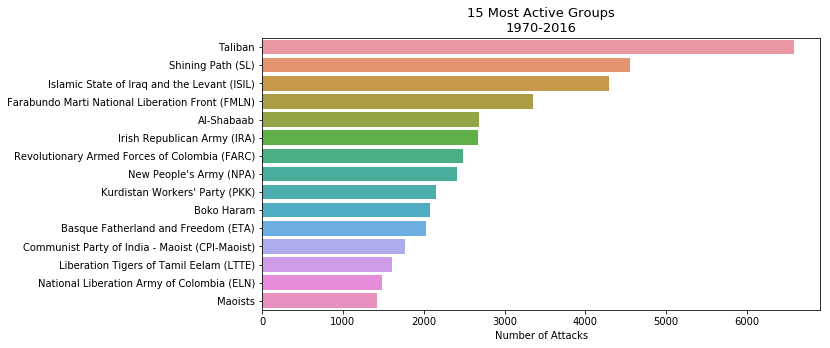

In [27]:
plt.subplots(figsize=(10, 5))
sns.barplot(top15.values, top15.index, orient='h')
plt.xlabel('Number of Attacks')
plt.title('15 Most Active Groups\n1970-2016', fontsize=13)

Most Volatile years

In [28]:
year_attacks = df.iyear.value_counts()
top15_years = year_attacks.sort_values(ascending=False).head(15)
top15_years

2014    16860
2015    14852
2016    13488
2013    11996
2012     8500
1992     5073
2011     5071
2010     4822
2008     4803
2009     4719
1991     4683
1989     4323
1990     3887
1988     3720
1984     3495
Name: iyear, dtype: int64

Text(0.5,1,'15 Most Volatile Years\n1970-2016')

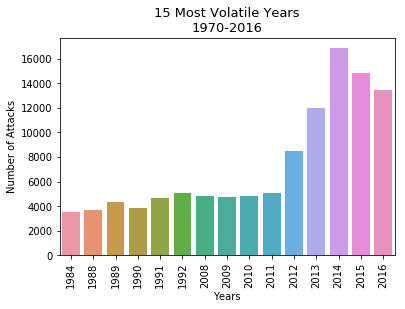

In [30]:
sns.barplot(top15_years.index, top15_years.values)
plt.xticks(rotation=90)
plt.ylabel('Number of Attacks')
plt.xlabel('Years')
plt.title('15 Most Volatile Years\n1970-2016', fontsize=13)


Terrorist attack by decades

In [31]:
bins = (1969, 1979, 1989, 1999, 2009, 2016)
labels = ['1970s', '1980s', '1990s', '2000s', '2010s']

year_decades = pd.cut(df.iyear, bins, labels=labels)
year_decades.head()

0    1970s
1    1970s
2    1970s
3    1970s
4    1970s
Name: iyear, dtype: category
Categories (5, object): [1970s < 1980s < 1990s < 2000s < 2010s]

In [32]:
year_decades_attacks = year_decades.value_counts()
year_decades_attacks

2010s    75589
1980s    31159
1990s    28766
2000s    24997
1970s     9839
Name: iyear, dtype: int64

Text(0.5,1,'Terrorist Attacks by Decades\n1970-2016')

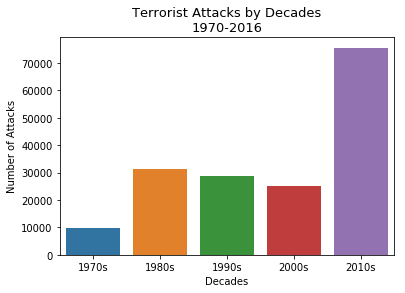

In [33]:
sns.barplot(year_decades_attacks.index, year_decades_attacks.values)
plt.xlabel('Decades')
plt.ylabel('Number of Attacks')
plt.title('Terrorist Attacks by Decades\n1970-2016', fontsize=13)

Countries most affected by terrorism

In [34]:
country_attacks = df.country_txt.value_counts()
top15_countries = country_attacks.head(15)
top15_countries

Iraq              22130
Pakistan          13634
Afghanistan       11306
India             10978
Colombia           8163
Philippines        6212
Peru               6088
El Salvador        5320
United Kingdom     5098
Turkey             4106
Thailand           3668
Somalia            3482
Nigeria            3418
Spain              3245
Yemen              3109
Name: country_txt, dtype: int64

Text(0.5,1,'15 Countries Most Affected by Terrorism\n1970-2016')

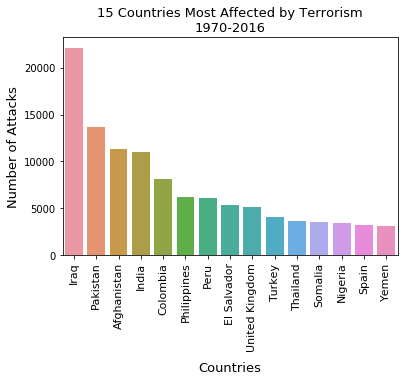

In [35]:
sns.barplot(top15_countries.index, top15_countries.values)
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Countries', labelpad=10, fontsize=13)
plt.ylabel('Number of Attacks', fontsize=13)
plt.title('15 Countries Most Affected by Terrorism\n1970-2016', fontsize=13)

Terrorist Attack by regions

In [36]:
region_attacks = df.region_txt.value_counts()
region_attacks

Middle East & North Africa     46511
South Asia                     41497
South America                  18762
Western Europe                 16307
Sub-Saharan Africa             15491
Southeast Asia                 11453
Central America & Caribbean    10340
Eastern Europe                  5031
North America                   3346
East Asia                        794
Central Asia                     554
Australasia & Oceania            264
Name: region_txt, dtype: int64

Text(0.5,1,'Terrorist Attacks by Regions\n1970-2016')

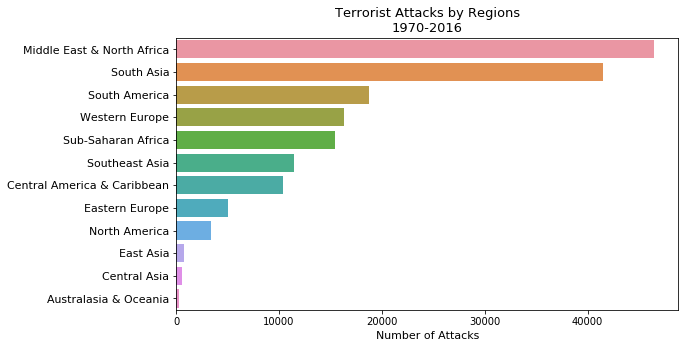

In [37]:
plt.subplots(figsize=(9, 5))
sns.barplot(region_attacks.values, region_attacks.index, orient='h')
plt.yticks(fontsize=11)
plt.xlabel('Number of Attacks', fontsize=11)
plt.title('Terrorist Attacks by Regions\n1970-2016', fontsize=13)

Modeling and model evaluation

In [38]:
df.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [39]:
df.shape

(170350, 135)

In [40]:
summary_gname = df.loc[:, ['summary','gname']]
summary_gname.head(3)

,summary,gname
0,NaN,MANO-D
1,NaN,23rd of September Communist League
2,NaN,Unknown


In [41]:
summary_gname.isnull().sum()

summary    66138
gname          0
dtype: int64

In [42]:
summary_gname.gname.value_counts().shape

(3454,)

Dropping summary null values

In [43]:
summary_gname.dropna(inplace=True)
summary_gname.head(3)

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang


In [44]:
summary_gname.shape

(104212, 2)

Separating known and unknown groups

In [45]:
(summary_gname.gname == 'Unknown').sum()

55159

In [47]:
(summary_gname.gname != 'Unknown').sum()

49053

In [48]:
unknown_grps = summary_gname.loc[summary_gname.gname == 'Unknown'].copy()
unknown_grps.head(3)

,summary,gname
7,1/2/1970: Unknown perpetrators detonated explo...,Unknown
40,1/31/1970: Unknown perpetrators bombed the Pol...,Unknown
43,2/2/1970: An incendiary device was discovered ...,Unknown


In [49]:
unknown_grps.shape

(55159, 2)

In [50]:
known_grps = summary_gname.loc[summary_gname.gname != 'Unknown'].copy()
known_grps.head(5)

,summary,gname
5,1/1/1970: Unknown African American assailants ...,Black Nationalists
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants


In [51]:
known_grps.shape

(49053, 2)

Samples of summary columns

In [52]:
known_grps.iloc[5,0]

"1/9/1970:  The Armed Commandos of Liberation claimed credit for setting a fire at the Baker's Store in Rio Piedras, Puerto Rico.  There were no casualties but the store was destroyed at a cost of $2,000,000."

In [53]:
known_grps.iloc[11,0]

'1/17/1970: Silas and Judith Bissell placed an explosive device in the vicinity of the Air Force R.O.T.C. at the University of Washington campus in Seattle, Washington, United States.  The device was discovered and subsequently disarmed.'

Encoding group names

In [54]:
grpCounts = known_grps.gname.value_counts()
grpCounts.head(10)

Taliban                                           6571
Islamic State of Iraq and the Levant (ISIL)       4287
Al-Shabaab                                        2683
Boko Haram                                        2077
Communist Party of India - Maoist (CPI-Maoist)    1766
New People's Army (NPA)                           1442
Maoists                                           1413
Revolutionary Armed Forces of Colombia (FARC)     1325
Tehrik-i-Taliban Pakistan (TTP)                   1252
Kurdistan Workers' Party (PKK)                    1127
Name: gname, dtype: int64

In [55]:
grpCounts.shape

(1582,)

Binning groups

In [56]:
bins = (0, 1, 10, 50, 100, 500, 10000)
labels = [1, 2, 3, 4, 5, 6]

grpCuts = pd.cut(grpCounts, bins, labels=labels)
grpCuts.head()

Taliban                                           6
Islamic State of Iraq and the Levant (ISIL)       6
Al-Shabaab                                        6
Boko Haram                                        6
Communist Party of India - Maoist (CPI-Maoist)    6
Name: gname, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [58]:
grpCuts.tail()

People's United Democratic Movement (PUDEMO)    1
Organization Alliance of Cuban Intransigence    1
Munadil al-Jumalyi Brigade                      1
Tehama Movement                                 1
Tolib Ayombekov loyalists                       1
Name: gname, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [59]:
grpCuts.value_counts().sort_index()

1    688
2    601
3    189
4     41
5     47
6     16
Name: gname, dtype: int64

In [60]:
df_grpCodes = pd.DataFrame({'Group Code':np.arange(1,7),
            'Number of Groups':grpCuts.value_counts().sort_index(),
            'Number of Attacks (Range)':['1', '2-10','10-50','50-100','100-500','500-10000']})
df_grpCodes.set_index('Group Code', inplace=True)
df_grpCodes

,Number of Attacks (Range),Number of Groups
Group Code,,
1,1,688
2,2-10,601
3,10-50,189
4,50-100,41
5,100-500,47
6,500-10000,16


In [61]:
df_grpCodes['Number of Groups'].sum()

1582

Group code dictionary

In [62]:
grpDict = {}
for grpCode in range(1, 7):
    grpDict[grpCode] = grpCuts[grpCuts.values == grpCode].index.tolist()

In [63]:
grpDict[6][:10]

['Taliban',
 'Islamic State of Iraq and the Levant (ISIL)',
 'Al-Shabaab',
 'Boko Haram',
 'Communist Party of India - Maoist (CPI-Maoist)',
 "New People's Army (NPA)",
 'Maoists',
 'Revolutionary Armed Forces of Colombia (FARC)',
 'Tehrik-i-Taliban Pakistan (TTP)',
 "Kurdistan Workers' Party (PKK)"]

In [64]:
grpDict[5][:10]

['Abu Sayyaf Group (ASG)',
 'Fulani extremists',
 'Separatists',
 'Palestinian Extremists',
 'National Liberation Army of Colombia (ELN)',
 'Algerian Islamic Extremists',
 'Tripoli Province of the Islamic State',
 'Hamas (Islamic Resistance Movement)',
 'Sinai Province of the Islamic State',
 'Chechen Rebels']

Mapping group name

In [65]:
def grpCodes(gname):
    for key, values in grpDict.items():
        if gname in values:
            return key

known_grps['gname_code'] = known_grps.gname.map(lambda x: grpCodes(x))
known_grps.head()

,summary,gname,gname_code
5,1/1/1970: Unknown African American assailants ...,Black Nationalists,4
8,"1/2/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
9,"1/3/1970: Karl Armstrong, a member of the New ...",New Year's Gang,2
11,1/6/1970: Unknown perpetrators threw a Molotov...,Left-Wing Militants,5
13,1/9/1970: Unknown perpetrators set off a fireb...,Left-Wing Militants,5


Group distributions

In [66]:
known_grps.gname_code.value_counts().sort_index()

1      688
2     2400
3     4371
4     2821
5    10480
6    28293
Name: gname_code, dtype: int64

In [67]:
df_grpCodes['Number of Attacks (Total)'] = known_grps.gname_code.value_counts().sort_index()
df_grpCodes

,Number of Attacks (Range),Number of Groups,Number of Attacks (Total)
Group Code,,,
1,1,688,688
2,2-10,601,2400
3,10-50,189,4371
4,50-100,41,2821
5,100-500,47,10480
6,500-10000,16,28293


Features and targets

In [68]:
X = known_grps.summary
y = known_grps.gname_code

In [69]:
X.shape, y.shape

((49053,), (49053,))

In [70]:
type(X), type(y)

(pandas.core.series.Series, pandas.core.series.Series)

Train test split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [72]:
splits = [X_train, X_test, y_train, y_test]
for _ in splits:
    print(_.shape)

(36789,)
(12264,)
(36789,)
(12264,)


Vectorising text

In [73]:
vect = CountVectorizer()

In [74]:
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [75]:
X_train_dtm = vect.transform(X_train)
X_train_dtm

<36789x43825 sparse matrix of type '<class 'numpy.int64'>'
	with 1590419 stored elements in Compressed Sparse Row format>

In [76]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<12264x43825 sparse matrix of type '<class 'numpy.int64'>'
	with 524888 stored elements in Compressed Sparse Row format>

Naive Bayes

In [78]:
nb = MultinomialNB()

In [79]:
%time nb.fit(X_train_dtm, y_train)

CPU times: user 37.6 ms, sys: 9.96 ms, total: 47.5 ms
Wall time: 46.7 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [80]:
y_pred_nb = nb.predict(X_test_dtm)

In [81]:
metrics.accuracy_score(y_test, y_pred_nb)

0.8531474233529028

In [82]:
metrics.confusion_matrix(y_test, y_pred_nb)

array([[   0,   26,   57,    7,   53,   36],
       [   0,  148,  139,   18,  173,  101],
       [   0,    8,  595,   23,  229,  176],
       [   0,    9,   68,  415,  145,   92],
       [   0,    8,   52,   36, 2381,  217],
       [   0,    5,   71,    8,   44, 6924]])

In [83]:
print(metrics.classification_report(y_test, y_pred_nb))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       179
          2       0.73      0.26      0.38       579
          3       0.61      0.58      0.59      1031
          4       0.82      0.57      0.67       729
          5       0.79      0.88      0.83      2694
          6       0.92      0.98      0.95      7052

avg / total       0.83      0.85      0.84     12264



Lr

In [84]:
lr = LogisticRegression()

In [85]:
%time lr.fit(X_train_dtm, y_train)

CPU times: user 9.68 s, sys: 142 ms, total: 9.82 s
Wall time: 10.1 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [86]:
y_pred_lr = lr.predict(X_test_dtm)

In [87]:
metrics.accuracy_score(y_test, y_pred_lr)

0.9292237442922374

In [88]:
metrics.confusion_matrix(y_test, y_pred_lr)

array([[  21,   62,   38,   12,   21,   25],
       [   9,  377,   81,   19,   64,   29],
       [   4,   44,  807,   26,   82,   68],
       [   3,    9,   26,  639,   20,   32],
       [   6,   18,   48,   11, 2583,   28],
       [   4,   13,   30,   14,   22, 6969]])

In [89]:
print(metrics.classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          1       0.45      0.12      0.19       179
          2       0.72      0.65      0.68       579
          3       0.78      0.78      0.78      1031
          4       0.89      0.88      0.88       729
          5       0.93      0.96      0.94      2694
          6       0.97      0.99      0.98      7052

avg / total       0.92      0.93      0.92     12264



A validation of K fold

In [90]:
def mean_clf(X, y, clf):
    
    accuracyScores = []
    f1Scores = []
    
    for iter in range(3):    
        
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        
        vect = CountVectorizer()
        vect.fit(X_train)
        X_train_dtm = vect.transform(X_train)
        X_test_dtm = vect.transform(X_test)

        clf.fit(X_train_dtm, y_train)
        y_pred = clf.predict(X_test_dtm)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred, average='weighted')
        accuracyScores.append(accuracy)
        f1Scores.append(f1)
    
    return accuracyScores, f1Scores

In [92]:
%%time
nb = MultinomialNB()
accuracy_nb, f1_nb = mean_clf(X, y, nb)
print(accuracy_nb)
print(f1_nb)

[0.8496412263535551, 0.8482550554468362, 0.8512720156555773]
[0.8303198254104621, 0.8284286644938085, 0.8312023929867969]
CPU times: user 11.2 s, sys: 450 ms, total: 11.6 s
Wall time: 11.8 s


In [93]:
%%time
lr = LogisticRegression()
accuracy_lr, f1_lr = mean_clf(X, y, lr)
print(accuracy_lr)
print(f1_lr)


[0.9328930202217873, 0.930365296803653, 0.9262067840834964]
[0.9286463302272631, 0.9251048874902211, 0.9205932742820675]
CPU times: user 39.5 s, sys: 690 ms, total: 40.1 s
Wall time: 41 s


In [94]:
pd.DataFrame({'Accuracy Score':[np.array(accuracy_nb).mean(), np.array(accuracy_lr).mean()],
             'F1 Score': [np.array(f1_nb).mean(), np.array(f1_lr).mean()]},
             index=['Naive Bayes','Logistic Regression'])

,Accuracy Score,F1 Score
Naive Bayes,0.849723,0.829984
Logistic Regression,0.929822,0.924781


Predicting unknown groups

In [95]:
%%time
vect = CountVectorizer()
vect.fit(X)
X_dtm = vect.transform(X)
unknown_grps_dtm = vect.transform(unknown_grps.summary)

CPU times: user 6.07 s, sys: 205 ms, total: 6.27 s
Wall time: 6.4 s


In [96]:
%%time
nb = MultinomialNB()
nb.fit(X_dtm, y)
unknown_grps_pred_nb = nb.predict(unknown_grps_dtm)
print(unknown_grps_pred_nb)

[4 4 4 ... 6 5 5]
CPU times: user 65.6 ms, sys: 21.8 ms, total: 87.4 ms
Wall time: 89.3 ms


In [97]:
%%time
lr = LogisticRegression()
lr.fit(X_dtm, y)
unknown_grps_pred_lr = lr.predict(unknown_grps_dtm)
print(unknown_grps_pred_lr)

[4 5 4 ... 6 5 2]
CPU times: user 14.3 s, sys: 204 ms, total: 14.5 s
Wall time: 14.9 s


In [98]:
nb_pred = pd.Series(unknown_grps_pred_nb).value_counts().sort_index()
nb_pred

1        1
2      518
3     4464
4     1131
5    14585
6    34460
dtype: int64

In [99]:
lr_pred = pd.Series(unknown_grps_pred_lr).value_counts().sort_index()
lr_pred

1      727
2     3128
3     6586
4     2607
5    13979
6    28132
dtype: int64

In [100]:
df_pred = pd.DataFrame({'Naive Bayes': nb_pred,
             'Logistic Regression': lr_pred,
             'Group Code': np.arange(1, 7)}).set_index('Group Code')
df_pred = df_pred[['Naive Bayes','Logistic Regression']]
df_pred

,Naive Bayes,Logistic Regression
Group Code,,
1,1,727
2,518,3128
3,4464,6586
4,1131,2607
5,14585,13979
6,34460,28132
